In [1]:
import csv
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
train_df = pd.read_csv('/hdd/datasets/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df = train_df.drop(train_df.columns[[2,3,4,5,6,7,8,9]], axis=1)
print(train_df.head())

comments = train_df['comment'].tolist()
comments = [i.split(' ') for i in comments if isinstance(i, str)]

   label                                            comment
0      0                                         NC and NH.
1      0  You do know west teams play against west teams...
2      0  They were underdogs earlier today, but since G...
3      0  This meme isn't funny none of the "new york ni...
4      0                    I could use one of those tools.


In [5]:
train_df['length'] = train_df['comment'].str.len()
train_df = train_df.dropna()

ax = train_df['length'].plot.hist(bins=50)

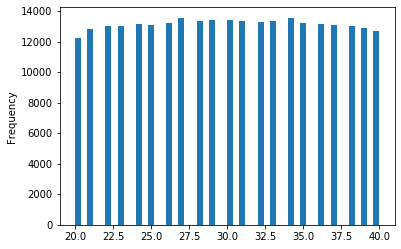

In [6]:
train_df = train_df[train_df['length'] <= 40]
train_df = train_df[train_df['length'] >= 20]
ax = train_df['length'].plot.hist(bins=50)

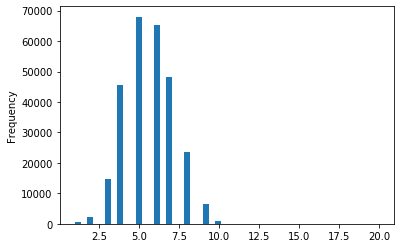

In [7]:
train_df['words'] = train_df['comment'].str.split().apply(len)
ax = train_df['words'].plot.hist(bins=50)
train_df = train_df[train_df['words'] >= 4]
train_df = train_df[train_df['words'] <= 7]

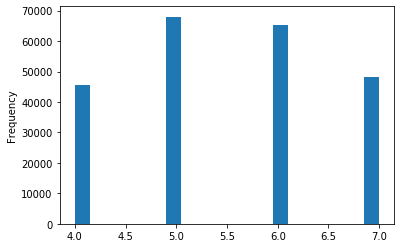

In [8]:
ax = train_df['words'].plot.hist(bins=20)

In [9]:
print(train_df.sort_index(by=['length'], ascending=False))
print(train_df['label'].value_counts())

        label                                   comment  length  words
121957      0  KENALKAN = pilihan kata yang lebih baik.    40.0      7
712719      1  Yeah but it's just because we're jealous    40.0      7
685393      1  The music definitely improved this video    40.0      6
909404      1  Are vaccinations also bad for your dogs?    40.0      7
485735      1  Stop being reasonable you stupid zionist    40.0      6
...       ...                                       ...     ...    ...
619907      1                      I miss CD Warehouse!    20.0      4
222064      0                      Too little too late.    20.0      4
619858      0                      What's on the stars?    20.0      4
619815      0                      20 cents a terabyte.    20.0      4
219503      0                      The state of denial?    20.0      4

[226826 rows x 4 columns]
1    116989
0    109837
Name: label, dtype: int64


/opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [10]:
comments = train_df['comment'].tolist()
comments = [i.split(' ') for i in comments if isinstance(i, str)]

In [11]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(comments)

tokens = tokenizer.texts_to_sequences(comments)

print(comments[:2])
print(tokens[:2])

[['I', 'could', 'use', 'one', 'of', 'those', 'tools.'], ['Blade', 'Mastery+Masamune', 'or', 'GTFO!']]
[[5, 116, 142, 53, 11, 82], [61]]


In [12]:
MAX_SEQUENCE_LENGTH = 7
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = np.array(pad_sequences(tokens, maxlen=MAX_SEQUENCE_LENGTH))

Found 117913 unique tokens.


In [13]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
old_data = data[indices]
old_labels = train_df['label'].values[indices]
data = []
labels = []

for datum, label in zip(old_data, old_labels):
    if datum[3] != 0:
        data.append(datum)
        labels.append(label)

data = np.asarray(data)
labels = to_categorical(np.asarray(labels))
num_validation_samples = int(0.3 * data.shape[0])

In [14]:
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Number of entries in each category:')
print("Training:\n",y_train.sum(axis=0))
print("Validation:\n",y_val.sum(axis=0))

Number of entries in each category:
Training:
 [40245. 47536.]
Validation:
 [17141. 20479.]


In [15]:
EMBEDDING_DIM = 7
# GLOVE_DIR = "/hdd/datasets/sarcasm/"
# embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.25d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print("Found %s word vectors." % len(embeddings_index))

In [16]:
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

W1203 17:55:36.488572 140002734540544 deprecation.py:506] From /opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 4, activation='relu')(embedded_sequences)
l_cov2= Conv1D(128, 2, activation='relu')(l_cov1)
l_flat = Flatten()(l_cov2)
drop = Dropout(0.5)(l_flat)
l_dense = Dense(128, activation='relu')(drop)
preds = Dense(2, activation='sigmoid')(l_dense)

W1203 17:55:36.501235 140002734540544 deprecation.py:506] From /opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
model.summary()

W1203 17:55:36.577415 140002734540544 deprecation.py:323] From /opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 7, 7)              825398    
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 128)            3712      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 128)            32896     
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dropout (Dropout)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               49280 

In [ ]:
print("Training Progress:")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=128)

Training Progress:
Train on 87781 samples, validate on 37620 samples
Epoch 1/100
87781/87781 [==============================] - 2s 28us/sample - loss: 0.6823 - acc: 0.5519 - val_loss: 0.6713 - val_acc: 0.5682
Epoch 2/100
87781/87781 [==============================] - 2s 17us/sample - loss: 0.6679 - acc: 0.5745 - val_loss: 0.6643 - val_acc: 0.5773
Epoch 3/100
87781/87781 [==============================] - 2s 17us/sample - loss: 0.6615 - acc: 0.5825 - val_loss: 0.6671 - val_acc: 0.5690
Epoch 4/100
87781/87781 [==============================] - 1s 17us/sample - loss: 0.6565 - acc: 0.5915 - val_loss: 0.6545 - val_acc: 0.5922
Epoch 5/100
30208/87781 [=========>....................] - ETA: 0s - loss: 0.6511 - acc: 0.5978